In [1]:
## Importa as bibliotecas iniciais a serem utilizadas
import numpy as np
import scipy.io as sio
from skimage import exposure
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from scipy.optimize import dual_annealing

In [13]:
def select_data():
    print("Select the image to be processed:")
    print("1.Flevoland - area 1")
    print("2.San Francisco")
    opcao=int(input("type the option:"))
    if opcao==1:
        imagem="/home/aborba/github/mb2021/Data/AirSAR_Flevoland_Enxuto.mat"
        ## Valores ajustados visualmente - precisa definir o valor do centro da rea corretamente
        ## AAB valores ajustado de acordo com o matlab
        dx=278
        dy=64
    else:
        imagem="/home/aborba/github/mb2021/Data/SanFrancisco_Bay.mat"
        dx=50
        dy=-195
    ## Raio usado nas radias
    RAIO = 120
    ## Numero de raios utilizado na definicao de bordas para circunferencia completa
    NUM_RAIOS=100
    ## angulo inicial para gerar as radiais
    alpha_i=0.0
    ## angulo final para gerar as radiais
    alpha_f=2*np.pi
    ## ajusta o numero de raios de acordo com o angulo
    if (alpha_f-alpha_i)!=(2*np.pi):
        NUM_RAIOS=int(NUM_RAIOS*(alpha_f-alpha_i)/(2*np.pi))

    return imagem, dx, dy, RAIO, NUM_RAIOS, alpha_i, alpha_f

In [14]:
## Le uma imagem no formato mat
def le_imagem(img_geral):
    img=sio.loadmat(img_geral)
    img_dat=img['S']
    img_dat=np.squeeze(img_dat)
    img_shp=img_dat.shape
    ## print(img_shp)
    ncols=img_shp[1]
    nrows=img_shp[0]
    nc=img_shp[len(img_shp)-1]
    return img_dat, nrows, ncols, nc

In [15]:
## Separa os canais e retorna uma imagem de visualizacao
def show_Pauli(data, index, control):
    Ihh = np.real(data[:,:,0])
    Ihv = np.real(data[:,:,1])
    Ivv = np.real(data[:,:,2])
    Ihh=np.sqrt(np.abs(Ihh))
    Ihv=np.sqrt(np.abs(Ihv))/np.sqrt(2)
    Ivv=np.sqrt(np.abs(Ivv))
    R = np.abs(Ihh - Ivv)
    G = (2*Ihv)
    B =  np.abs(Ihh + Ivv)
    R = exposure.equalize_hist(R)
    G = exposure.equalize_hist(G)
    B = exposure.equalize_hist(B)
    II = np.dstack((R,G,B))
    HSV = mpl.colors.rgb_to_hsv(II)
    Heq = exposure.equalize_hist(HSV[:,:,2])
    HSV_mod = HSV
    HSV_mod[:,:,2] = Heq
    Pauli_Image= mpl.colors.rgb_to_hsv(HSV_mod)
    return Pauli_Image

In [16]:
## Define as radiais
def define_radiais(r, num_r, dx, dy, nrows, ncols, start, end):
    x0 = ncols / 2 - dx
    y0 = nrows / 2 - dy
    t = np.linspace(start, end, num_r, endpoint=True)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    xr= np.round(x)
    yr= np.round(y)
    return x0, y0, xr, yr

In [17]:
## Bresenham
def bresenham(x0, y0, xf, yf):
    x=xf-x0
    y=yf-y0
    m=y*1.0/x
    ## Se m < 0 entao esta no 2o ou 4o quadrante
    if m<0:
        ## Se |m| <= 1 entao esta no 4o ou no 8o octante
        if abs(m)<= 1:
            ## Se x > 0 entao esta no 8o octante
            if x>0:
                y=y*-1
                xp,yp=bresenham_FirstOctante(x,y)
                yp=list(np.asarray(yp)*-1)
            ## senao esta no 4o octante
            else:
                x=x*-1
                xp,yp=bresenham_FirstOctante(x,y)
                xp=list(np.asarray(xp)*-1)
        ## senao esta no 3o ou no 7o octante
        else:
            ## Se y > 0 entao esta no 3o octante
            if y>0:
                x=x*-1
                x,y = y,x
                xp,yp=bresenham_FirstOctante(x,y)
                xp,yp = yp,xp
                xp=list(np.asarray(xp)*-1)
            ## senao esta no 7o octante
            else:
                y=y*-1
                x,y = y,x
                xp,yp=bresenham_FirstOctante(x,y)
                xp,yp = yp,xp
                yp=list(np.asarray(yp)*-1)
    ## senao esta no 1o quadrante ou no 3o quadrante
    else:
        ## Se |m| <= 1 entao esta no 1o ou no 5o octante
        if abs(m)<= 1:
            ## Se x > 0 entao esta no 1o octante
            if x>0:
                xp,yp=bresenham_FirstOctante(x,y)
            ## senao esta no 5o octante
            else:
                x=x*-1
                y=y*-1
                xp,yp=bresenham_FirstOctante(x,y)
                xp=list(np.asarray(xp)*-1)
                yp=list(np.asarray(yp)*-1)
        ## senao esta no 2o ou no 6o octante
        else:
            ## Se y > 0 entao esta no 2o octante
            if y>0:
                x,y = y,x
                xp,yp=bresenham_FirstOctante(x,y)
                xp,yp = yp,xp
            ## senao esta no 6o octante
            else:
                y=y*-1
                x=x*-1
                x,y = y,x
                xp,yp=bresenham_FirstOctante(x,y)
                xp,yp = yp,xp
                xp=list(np.asarray(xp)*-1)
                yp=list(np.asarray(yp)*-1)
    xp= list(np.asarray(xp) + x0)
    yp= list(np.asarray(yp) + y0)
    return xp, yp

In [18]:
def bresenham_FirstOctante(xf, yf):
    x=int(xf)
    y=int(yf)
    xp=[]
    yp=[]
    xp.append(0)
    yp.append(0)
    x_temp=0
    y_temp=0
    pk=2*y-x
    for i in range(x-1):
        ## print(pk)
        if pk<0:
            pk=pk+2*y
            x_temp=x_temp+1
            y_temp=y_temp
        else:
            pk=pk+2*y-2*x
            x_temp=x_temp+1
            y_temp=y_temp+1
        xp.append(int(x_temp))
        yp.append(int(y_temp))
    xp.append(x)
    yp.append(y)
    return xp, yp

In [19]:
## Testa se os pontos extremos dos raios estao fora da imagem
def test_XY(XC, YC, j, tam_Y, tam_X):
    if XC[j]<0:
        X=0
    elif XC[j]>=tam_X:
        X=tam_X-1
    else:
        X=XC[j]
    if YC[j]<0:
        Y=0
    elif YC[j]>=tam_Y:
        Y=tam_Y-1
    else:
        Y=YC[j]
    return int(X), int(Y)


In [20]:
## Desenha os raios e determina os pixels de amostragem usando o algoritmo de bresenham
def desenha_raios(ncols, nrows, nc, RAIO, NUM_RAIOS, img, PI, x0, y0, xr, yr):
    ## Cria vetors e matrizes de apoio
    IT = np.zeros([nrows, ncols])
    const =  5 * np.max(np.max(np.max(PI)))
    MXC = np.zeros([NUM_RAIOS, RAIO])
    MYC = np.zeros([NUM_RAIOS, RAIO])
    MY  = np.zeros([NUM_RAIOS, RAIO, nc])
    for i in range(NUM_RAIOS):
        XC, YC = bresenham(x0, y0, xr[i], yr[i])
        ##print(XC[0], YC[0], XC[len(XC)-1], YC[len(YC)-1])
        for canal in range(nc):
            Iaux = img[:, :, canal]
            dim = len(XC)
            for j in range(dim - 1):
                ##print(i, canal, j, dim)
                X,Y = test_XY(XC, YC, j, nrows, ncols)
                #print(X,Y)
                # AAB: Swap X to Y. To obtain the same results that matlab program
                MXC[i][j] = X
                MYC[i][j] = Y
                # AAB: Swap X to Y. To obtain the same results that matlab programs
                MY[i][j][canal] = Iaux[Y][X]
                # AAB: Swap X to Y. To obtain the same results that matlab programs
                IT[Y][X] = const
                PI[Y][X] = const
    return MXC, MYC, MY, IT, PI

In [21]:
def func_obj_l_L_mu(j, z, n, matdf1, matdf2):
    j = int(np.round(j))
    mue = matdf1[j, 0]
    Le  = matdf1[j, 1]
    mud = matdf2[j, 0]
    Ld  = matdf2[j, 1]
    somaze = sum(z[0: j]) / j
    somalogze = sum(np.log(z[0: j])) / j
    somazd = sum(z[j: n]) / (n - j)
    somalogzd = sum(np.log(z[j: n])) / (n - j)
    #
    aux1 = Le * np.log(Le)
    aux2 = Le * somalogze
    aux3 = Le * np.log(mue)
    aux4 = np.log(math.gamma(Le))
    aux5 = (Le / mue) *  somaze
    #
    aux6  = Ld * np.log(Ld)
    aux7  = Ld * somalogzd
    aux8  = Ld * np.log(mud)
    aux9  = np.log(math.gamma(Ld))
    aux10 = (Ld / mud) * somazd
    a1 =  aux1 + aux2 - aux3 - aux4 - aux5
    a2 =  aux6 + aux7 - aux8 - aux9 - aux10
    #### AAB  Beware! The signal is negative because GenSA finds the point of minimum
    func_obj_l_L_mu = -(j * a1 + (n - j) * a2)
    return func_obj_l_L_mu

In [22]:
def which(self):
    try:
        self = list(iter(self))
    except TypeError as e:
        raise Exception("""'which' method can only be applied to iterables.
        {}""".format(str(e)))
    indices = [i for i, x in enumerate(self) if bool(x) == True]
    return(indices)

In [27]:
imagem, dx, dy, RAIO, NUM_RAIOS, alpha_i, alpha_f = select_data()
## Le a imagem e retorna a imagem, tamanho da imagem e numero de canais
img, nrows, ncols, nc = le_imagem(imagem)
## print(ncols, nrows, nc)
## CRia a imagem de Pauli e mostra a imagem gerada
PI=show_Pauli(img, 1, 0)
## Define os raios da area
x0, y0, xr, yr=define_radiais(RAIO, NUM_RAIOS, dx, dy, nrows, ncols, alpha_i, alpha_f)
#
MXC, MYC, MY, IT, PI=desenha_raios(ncols, nrows, nc, RAIO, NUM_RAIOS, img, PI, x0, y0, xr, yr)
#

Select the image to be processed:
1.Flevoland - area 1
2.San Francisco
type the option:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


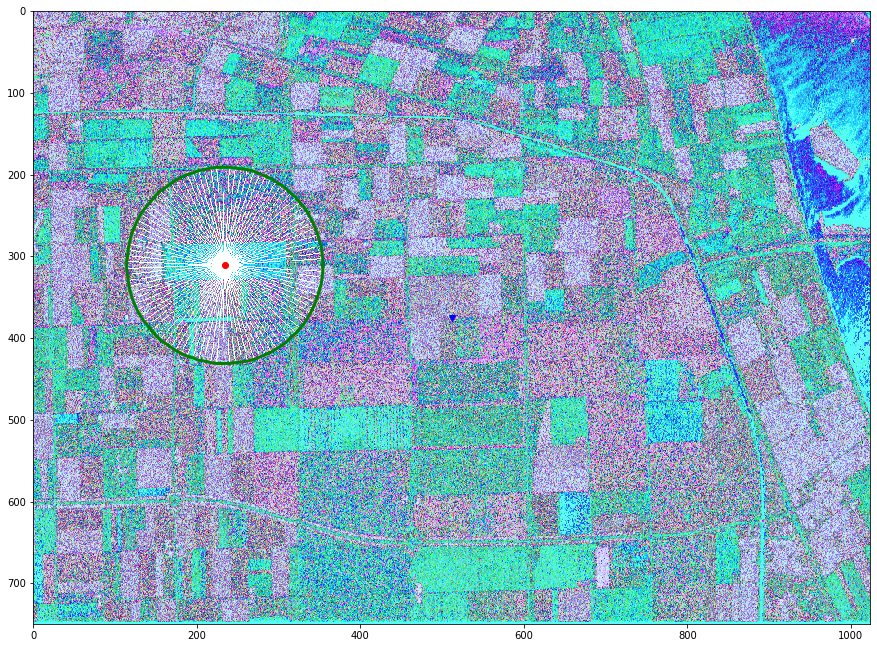

In [28]:
plt.figure(figsize=(15,20))
plt.plot(ncols/2, nrows/2, marker='v', color="blue")
plt.plot(x0,y0, marker='o', color="red")
plt.plot(xr, yr, color="green", linewidth=3)
plt.imshow(PI)
plt.show()

In [34]:
#
z = np.zeros(RAIO)
L = 4
Le = 4
Ld = 4
# nc = 9
# AAB momentaneamente uso ncanal=3
ncanal = 3
evidencias = np.zeros((NUM_RAIOS, 3))
for canal in range(ncanal):
    print(canal)
    for k in range(NUM_RAIOS):
        N = RAIO
        z = MY[k, :, canal]
        zaux = np.zeros(N)
        conta = 0
        for i in range(0, N):
            if z[i] > 0:
                zaux[conta] = z[i]
                conta = conta + 1
            #
        indx  = which(zaux != 0)
        N = int(np.max(indx))
        z =  zaux[1:N]
        matdf1 =  np.zeros((N, 2))
        matdf2 =  np.zeros((N, 2))
        for j in range(1, N):
            mue = sum(z[0: j]) / j
            matdf1[j, 0] = mue
            matdf1[j, 1] = Le
            mud = sum(z[j: (N + 1)]) / (N - j)
            matdf2[j, 0] = mud
            matdf2[j, 1] = Ld
#
        lw = [14] * 1
        up = [N - 14] * 1
    #ret = dual_annealing(func_obj_l_L_mu, bounds=list(zip(lw, up)), args=(z, N, matdf1, matdf2), seed=1234)
        ret = dual_annealing(lambda x:func_obj_l_L_mu(x,z, N, matdf1, matdf2), bounds=list(zip(lw, up)), seed=1234)
        evidencias[k, canal] = np.round(ret.x)

0
1
2


In [35]:
IM  = np.zeros([nrows, ncols, ncanal])
for canal in range(ncanal):
    for k in range(NUM_RAIOS):
        ik = np.int(evidencias[k, canal])
        ia = np.int(MXC[k, ik])
        ja = np.int(MYC[k, ik])
        IM[ja, ia, canal] = 1

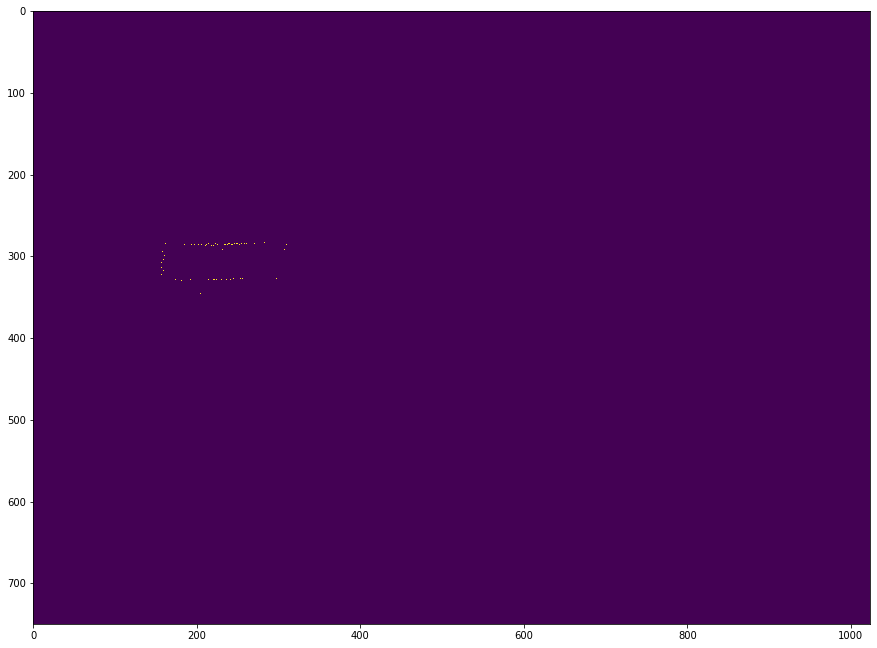

In [36]:
# Plot para o canal hh
plt.figure(figsize=(15,20))
#plt.plot(ncols/2, nrows/2, marker='v', color="blue")
#plt.plot(x0,y0, marker='o', color="red")
#plt.plot(xr, yr, color="green", linewidth=3)
plt.imshow(IM[:, :, 0])
plt.show()

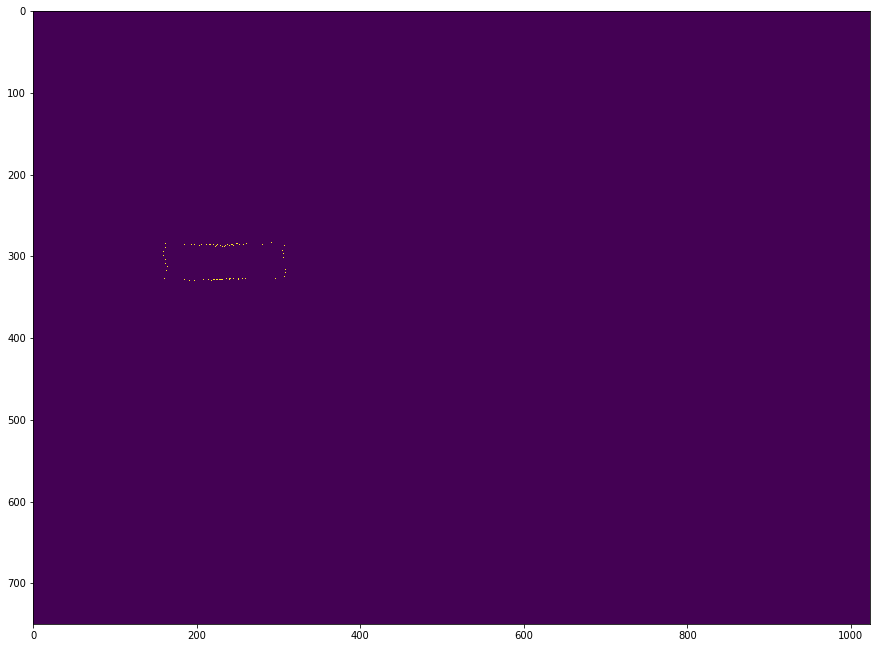

In [37]:
# Plot para o canal hv
plt.figure(figsize=(15,20))
#plt.plot(ncols/2, nrows/2, marker='v', color="blue")
#plt.plot(x0,y0, marker='o', color="red")
#plt.plot(xr, yr, color="green", linewidth=3)
plt.imshow(IM[:, :, 1])
#plt.imshow(PI)
plt.show()

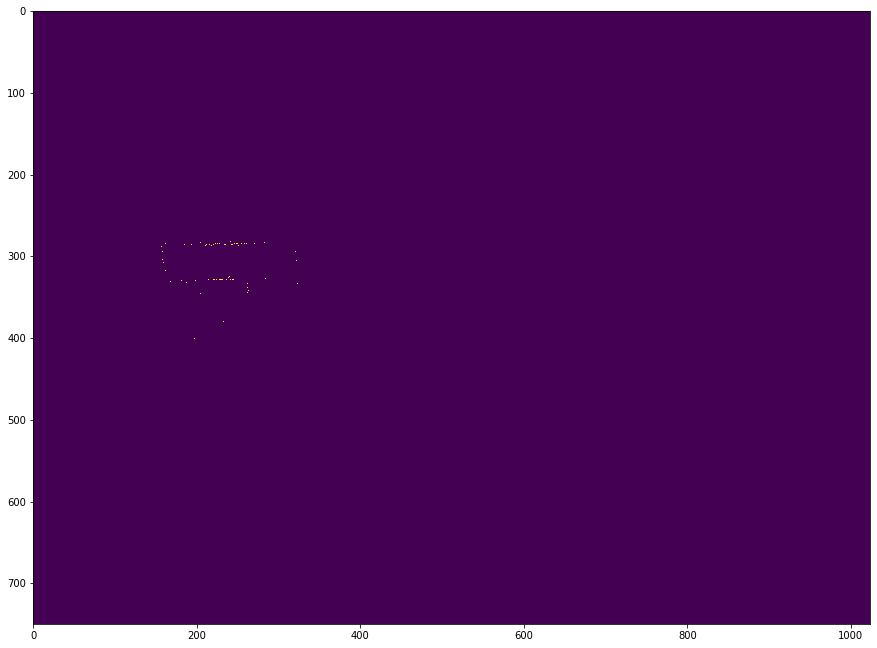

In [33]:
# Plot para o canal vv
plt.figure(figsize=(15,20))
#plt.plot(ncols/2, nrows/2, marker='v', color="blue")
#plt.plot(x0,y0, marker='o', color="red")
#plt.plot(xr, yr, color="green", linewidth=3)
plt.imshow(IM[:, :, 2])
plt.show()